# PyCUDA 图像处理 图像卷积

In [2]:
import pycuda.autoinit
import pycuda.driver as drv
import numpy as np
from pycuda.compiler import SourceModule
import string
import cv2
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import  animation

In [3]:
def load_kernel_from_file(fname,kname):
    sources = None
    kernel = None
    with open(fname) as f:
        sources = f.read() # 通过str函数转换为unicode编码
        sm = SourceModule(str(sources))
        kernel = sm.get_function(kname)
    return kernel

def load_kernel_from_string(sources,kname):
    sm = SourceModule(str(sources))
    kernel = sm.get_function(kname)
    return kernel

In [3]:
convolution_2D = load_kernel_from_file('../../datas/cuda/11-convolution.cu','convolution_2D_kernel')

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h: warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(838): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(1772): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(2628): warning C4819: The file

In [4]:
convolution_tile = load_kernel_from_file('../../datas/cuda/12-convolution-tile.cu','convolution_tile')

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h: warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(838): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(1772): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(2628): warning C4819: The file

In [5]:
convolution_shared = load_kernel_from_file('../../datas/cuda/13-convolution-shared.cu','convolution')

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h: warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(838): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(1772): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(2628): warning C4819: The file

In [6]:
conv_1d = load_kernel_from_file('../../datas/cuda/14-convolution-1d.cu','convolution_1D_basic_kernel')

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h: warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(838): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(1772): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(2628): warning C4819: The file

In [4]:
src = cv2.cvtColor(cv2.imread('../../datas/f2.jpg'),cv2.COLOR_BGR2RGB)

In [8]:
mask_data_5x5 = np.array([[2 ,4, 5, 4, 2],
[4 ,9 ,12 ,9 ,4],
[5 ,12 ,15, 12, 5],
[4 ,9 ,12 ,9 ,4],
[2 ,4, 5, 4, 2]]).astype(np.float32) / 25
mask_rows = 3
rows,cols,ch = src.shape
dst = np.zeros_like(src).astype(np.float32)
mask_data = np.array([
    [-1,-1,-1],
    [-1,8,-1],
    [-1,-1,-1]
]).astype(np.float32)

In [9]:
tile_width = 12
block = (tile_width + 4,tile_width + 4,1)
grid = (int((cols - 1) / (tile_width) + 1),int((rows - 1) / tile_width + 1))

In [10]:
convolution_2D(drv.In(src.astype(np.float32)),drv.Out(dst),
                     np.int32(rows),np.int32(cols),np.int32(ch),
                     drv.In(mask_data),np.int32(mask_rows),grid=grid,block=block)

In [11]:
dst[dst < 0] = 0
dst[dst > 255] = 255
dst = dst.astype(np.uint8)

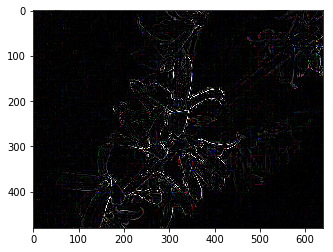

In [12]:
plt.imshow(dst)

In [13]:
dst2 = np.zeros_like(src).astype(np.float32)

In [14]:
def gen_constant_filter(maskwidth):
    mask = np.zeros((maskwidth * maskwidth,),dtype=np.float32)
    for x in range(maskwidth):
        for y in range(maskwidth):
            mask[x * maskwidth + y] = 1.0 / (maskwidth * maskwidth)
    return mask

def gen_identity_filter(maskwidth):
    mask = np.zeros((maskwidth * maskwidth,),dtype=np.float32)
    mask[len(mask) // 2] = 1
    return mask

def gen_gaussian_filter(maskwidth,sigma):
    mask = np.zeros((maskwidth * maskwidth,),dtype=np.float32)
    r = 2.0 * sigma * sigma
    s = r
    sum_val = 0.0
    center = maskwidth // 2
    for x in range(-center,center+1):
        for y in range(-center,center+1):
            r = np.sqrt(x * x + y * y)
            mask[(x + center) * maskwidth + y + center] = np.exp(-(r*r) / s) / (np.pi * s)
            sum_val += mask[(x + center) * maskwidth + y + center]
            
    for i in range(maskwidth):
        for j in range(maskwidth):
            mask[i * maskwidth + j] /= sum_val
    return mask

In [15]:
mask_constant_5x5 = gen_constant_filter(5).reshape(5,5)
mask_identity_5x5 = gen_identity_filter(5).reshape(5,5)
mask_guassian_5x5 = gen_gaussian_filter(5,2.4).reshape(5,5)
print(mask_guassian_5x5.reshape((5,5)))
mask_data2 = np.array([
    [-1,-1,-1,-1,-1],
    [-1, 1, 1, 1,-1],
    [-1, 1, 8, 1, -1],
    [-1, 1, 1, 1 ,-1],
    [-1,-1,-1,-1,-1]
]).astype(np.float32)

[[0.02768475 0.03592015 0.03917755 0.03592015 0.02768475]
 [0.03592015 0.04660534 0.05083172 0.04660534 0.03592015]
 [0.03917755 0.05083172 0.05544138 0.05083172 0.03917755]
 [0.03592015 0.04660534 0.05083172 0.04660534 0.03592015]
 [0.02768475 0.03592015 0.03917755 0.03592015 0.02768475]]


In [16]:
# mask_rows = 5
# convolution_2D(drv.In(src.astype(np.float32)),drv.Out(dst2),
#                      np.int32(rows),np.int32(cols),np.int32(ch),
#                      drv.In(mask_guassian_5x5),np.int32(mask_rows),grid=grid,block=block)

In [17]:
convolution_2D(drv.In(src.astype(np.float32)),drv.Out(dst2),
                     np.int32(rows),np.int32(cols),np.int32(ch),
                     drv.In(mask_data2),np.int32(mask_rows),grid=grid,block=block)

In [18]:
dst2[dst2 < 0] = 0
dst2[dst2 > 255] = 255
dst2 = dst2.astype(np.uint8)

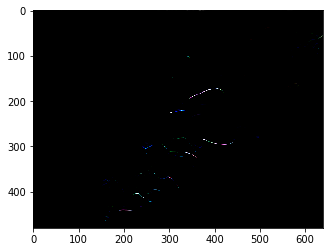

In [19]:
plt.imshow(dst2)

In [20]:
src_r = src[:,:,0]#cv2.cvtColor(src,cv2.COLOR_RGB2GRAY)
src_g = src[:,:,1]
src_b = src[:,:,2]

In [21]:
input_data_r = src_r.reshape((rows * cols,)).astype(np.int32)
input_data_g = src_g.reshape((rows * cols,)).astype(np.int32)
input_data_b = src_b.reshape((rows * cols,)).astype(np.int32)

In [22]:
mask_width = 7
mask_data = np.array([1,1,1,-6,1,1,1])
dst_1d_r = np.zeros_like(input_data_r)
dst_1d_g = np.zeros_like(input_data_g)
dst_1d_b = np.zeros_like(input_data_b)
length = len(input_data_r)
grid = (int(length / 32),1,1)
block = (32,1,1)

In [23]:
conv_1d(drv.In(input_data_r),drv.In(mask_data),drv.Out(dst_1d_r),
       np.int32(mask_width),np.int32(length),grid=grid,block=block)

In [24]:
conv_1d(drv.In(input_data_g),drv.In(mask_data),drv.Out(dst_1d_g),
       np.int32(mask_width),np.int32(length),grid=grid,block=block)

In [25]:
conv_1d(drv.In(input_data_b),drv.In(mask_data),drv.Out(dst_1d_b),
       np.int32(mask_width),np.int32(length),grid=grid,block=block)

In [5]:
convolute_kernel = load_kernel_from_file('../../datas/cuda/35-convolute.cu','convolute')

C:\Users\jenson\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: The CUDA compiler succeeded, but said the following:
kernel.cu
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h: warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(838): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(1772): warning C4819: The file contains a character that cannot be represented in the current code page (936). Save the file in Unicode format to prevent data loss
c:\program files\nvidia gpu computing toolkit\cuda\v9.1\include\crt\math_functions.h(2628): warning C4819: The file

In [6]:
sr,sg,sb = src[:,:,0].copy().astype(np.float32),src[:,:,1].copy().astype(np.float32),src[:,:,2].copy().astype(np.float32)

In [7]:
dr = np.zeros_like(sr)
dg = np.zeros_like(sg)
db = np.zeros_like(sb)
rows,cols = sr.shape
block = (1,1,1)
grid = (int(cols/block[0]),int(rows/block[1]),1)
radius = np.int32(5)
convolute_kernel(drv.In(sr),drv.Out(dr),np.int32(rows),np.int32(cols),radius,block=block,grid=grid)
convolute_kernel(drv.In(sg),drv.Out(dg),np.int32(rows),np.int32(cols),radius,block=block,grid=grid)
convolute_kernel(drv.In(sb),drv.Out(db),np.int32(rows),np.int32(cols),radius,block=block,grid=grid)

LaunchError: cuCtxSynchronize failed: unspecified launch failure